In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_path = '../data_src'
df = pd.read_csv(os.path.join(data_path, 'balanced_generated_datav2.csv'))

# Data Analysis

In [4]:
df.head(2)

,RPC_RATE,KEPT_RATE,NRPC_RATE,MONTH_END_DPD,Total_Score,Risk_Level
0,77.617247,60.922130,91.290787,200,20,3
1,11.351964,14.241049,83.307706,200,8,5


In [5]:
df.shape

(5000, 6)

In [6]:
df.isnull().sum()

RPC_RATE         0
KEPT_RATE        0
NRPC_RATE        0
MONTH_END_DPD    0
Total_Score      0
Risk_Level       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RPC_RATE       5000 non-null   float64
 1   KEPT_RATE      5000 non-null   float64
 2   NRPC_RATE      5000 non-null   float64
 3   MONTH_END_DPD  5000 non-null   int64  
 4   Total_Score    5000 non-null   int64  
 5   Risk_Level     5000 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 234.5 KB


In [8]:
df = df.drop(columns=[
  'Total_Score',
  'NRPC_RATE'])

In [9]:
df.head()

,RPC_RATE,KEPT_RATE,MONTH_END_DPD,Risk_Level
0,77.617247,60.922130,200,3
1,11.351964,14.241049,200,5
2,57.929456,83.644308,100,3
3,49.830623,3.972980,30,2
4,67.841576,69.097482,30,1


### One-Hot Encoding

In [10]:
df = pd.get_dummies(df)

In [11]:
df.head(2)

,RPC_RATE,KEPT_RATE,MONTH_END_DPD,Risk_Level
0,77.617247,60.922130,200,3
1,11.351964,14.241049,200,5


In [12]:
df.shape

(5000, 4)

In [13]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('overfitted|underfitted').any(), axis=1)]
print(len(df))

print("Filtered CSV file generated successfully!")

5000
Filtered CSV file generated successfully!


# Model Building and Selection

In [14]:
X = df.drop('Risk_Level', axis=1)
y = df['Risk_Level']

### Divide dataset into training and testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [17]:
X_train.shape, X_test.shape

((3750, 3), (1250, 3))

### Model Training

In [18]:
def model_acc(model):
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(str(model)+ ' --> ' +str(acc))

In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model_acc(lr)

from sklearn.linear_model import Lasso
lasso = Lasso()
model_acc(lasso)

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
model_acc(dt)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
model_acc(rf)

LinearRegression() --> 0.8226456398570225
Lasso() --> 0.8226637775014476
DecisionTreeRegressor() --> 0.7944508321563533
RandomForestRegressor() --> 0.8761615338103039


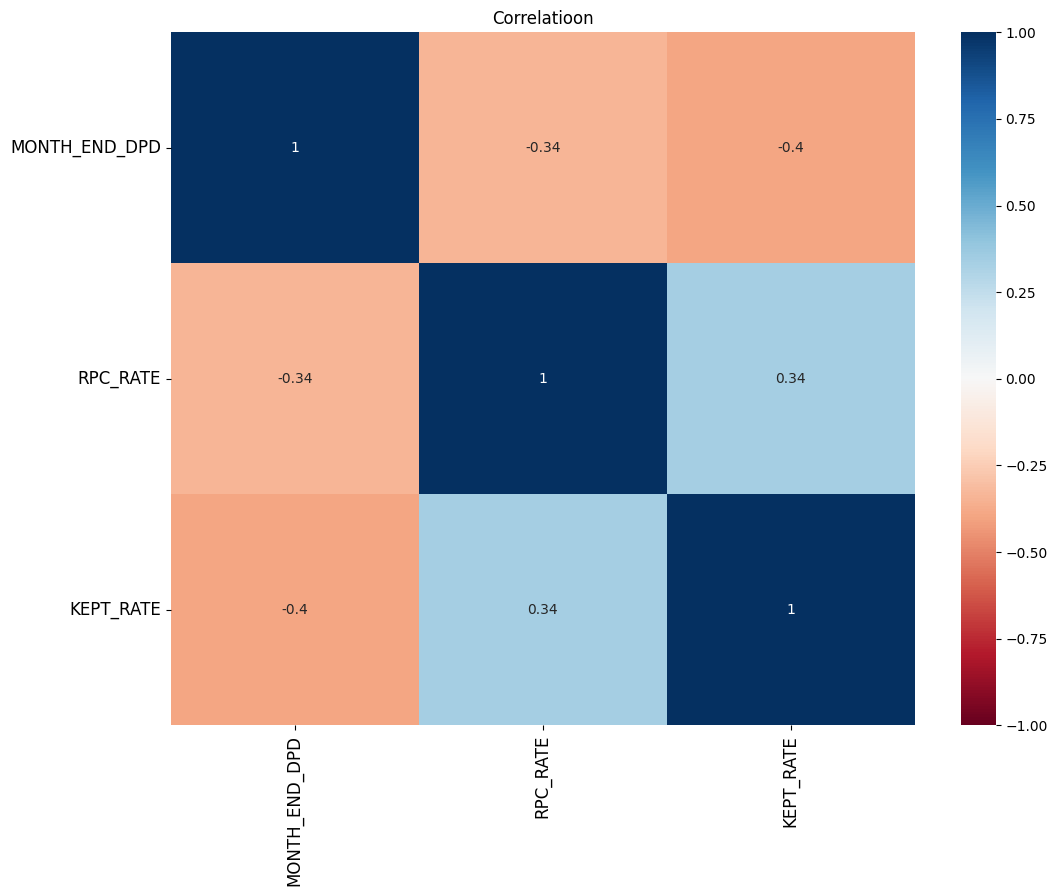

In [21]:
plt.figure(figsize = (12,9))
data1 = df[['MONTH_END_DPD', 'RPC_RATE', 'KEPT_RATE']]

s = sns.heatmap(data1.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Correlatioon")
plt.show()

### Hyperparameter tunning

In [22]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 50, 100],
              'criterion':['squared_error','absolute_error','poisson']}

grid_obj = GridSearchCV(estimator=rf, param_grid=parameters)

grid_fit = grid_obj.fit(X_train, y_train)

best_model = grid_fit.best_estimator_

best_model.score(X_test, y_test)

0.8770623299090693

In [23]:
X_test.columns

Index(['RPC_RATE', 'KEPT_RATE', 'MONTH_END_DPD'], dtype='object')

### Save model

In [24]:
# import joblib

# # Save the model
# joblib.dump(best_model, 'predictor.joblib')

# # Load the model
# best_model = joblib.load('predictor.joblib')
# lst = [100,0,90]
# pred_value = best_model.predict([lst])
# pred_value


In [25]:
import pickle

with open('../model/model.pkl', 'wb') as f:
    pickle.dump(best_model, f, protocol=4)